<a href="https://colab.research.google.com/github/amartsin/SIFFCM/blob/main/SIFFCM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import numpy as np
from scipy import signal


In [4]:
def getGaussianElement(a,b,stda,stdb,quad=None):
   

    assert a>0 and int(a)==a, "Major half-axis 'a' needs to be an positive integer."
    assert b>0 and int(b)==b, "Minor half-axis 'b' needs to be an positive integer."
    assert stda>0, "Standard deviation 'stda' needs to be an positive integer."
    assert stdb>0, "Standard deviation 'stdb' needs to be an positive integer."
    assert quad in [None,'ne','nw','sw','se'], "Quadrant should be one in the list [None, 'ne','nw','sw','se']."
    ax=np.arange(-a,a+1)
    bx=np.arange(-b,b+1)
    x,y=np.meshgrid(ax,bx)
    ellipse=0.5*np.pi/stda/stdb*np.exp(-x**2/2./stda**2 - y**2/2./stdb**2)

    if quad is not None:
        if quad=='ne':
            ellipse=np.where((ellipse>0) & (x>=0) & (y>=0),ellipse,0)
        elif quad=='nw':
            ellipse=np.where((ellipse>0) & (x<=0) & (y>=0),ellipse,0)
        elif quad=='sw':
            ellipse=np.where((ellipse>0) & (x<=0) & (y<=0),ellipse,0)
        elif quad=='se':
            ellipse=np.where((ellipse>0) & (x>=0) & (y<=0),ellipse,0)
    return ellipse



In [5]:
class FCM():
    def __init__(self,image,n_clusters,m=2,kernel_size=5,kernel_shape='uniform',lam=0.5,epsilon=0.05,max_iter=300):
        if np.ndim(image) != 2:
            raise Exception("<image> needs to be 2D (gray scale image).")
        if n_clusters <= 0 or n_clusters != int(n_clusters):
            raise Exception("<n_clusters> needs to be positive integer.")
        if m < 1:
            raise Exception("<m> needs to be >= 1.")
        if kernel_size <=0 or kernel_size != int(kernel_size):
            raise Exception("<kernel_size> needs to be positive integer.")
        if kernel_shape not in ['uniform', 'gaussian']:
            raise Exception("<kernel_shape> needs to be one of 'uniform', 'gaussian'.")
        if lam <= 0:
            raise Exception("<lam> needs to be > 0.")
        if epsilon <= 0:
            raise Exception("<epsilon> needs to be > 0")

        self.image = image
        self.n_clusters = n_clusters
        self.m = m
        self.kernel_size = kernel_size
        self.kernel_shape = kernel_shape
        self.lam = lam
        self.epsilon = epsilon
        self.max_iter = max_iter

        self.shape = image.shape
        self.X = image.flatten().astype('float')
        self.numPixels = image.size
        self.U = np.zeros((self.numPixels, self.n_clusters))
        idx = np.arange(self.numPixels)
        for ii in range(self.n_clusters):
            idxii = idx%self.n_clusters==ii
            self.U[idxii,ii] = 1
        self.C = np.linspace(np.min(image),np.max(image),n_clusters)
        self.C = self.C.reshape(self.n_clusters,1)

  

        #---------------Neighbourhood kernel---------------
        if kernel_shape == 'uniform':
            self.kernel = np.ones([kernel_size,kernel_size,1])
        if kernel_shape == 'gaussian':
            radius = max(1,int(kernel_size/.2))
            stdr = max(1,int(radius/.2))
            self.kernel = getGaussianElement(radius,radius,stdr,stdr)

        #----------------Initial hesitation----------------
        self.hesitation = 1.-self.U-(1.-self.U)/(1.+2.*self.U)
    def update_U(self):
        '''Compute weights'''
        c_mesh,x_mesh = np.meshgrid(self.C,self.X)
        power = 2./(self.m-1)
        p1 = abs(x_mesh-c_mesh)**power
        p2 = np.sum((1./abs(x_mesh-c_mesh))**power,axis=1)

        return 1./(p1*p2[:,None])


    def update_C(self):
        '''Compute centroid of clusters'''
        num = np.dot(self.X,self.U**self.m)
        den = np.sum(self.U**self.m,axis=0)

        return num/den


    def calculate_h(self):
        '''Compute neighbourhood weights'''
        kernel = np.ones((5,5,1))
        uu = self.U.reshape((self.shape+(self.n_clusters,)))
        h = signal.fftconvolve(uu,kernel,mode='same')
        h = h.reshape(self.U.shape)

        return h
    def compute_intuitionistic_U(self):
        '''Compute intuitionistic U'''
        self.hesitation=1.-self.U-(1-self.U)/(1+self.lam*self.U)

        return self.U+self.hesitation


    def computeNew_U(self):
        '''Compute new weights after incorporating spatial and intuitionistic'''
        p = 1
        #q = 2
        q = 3
        self.h = self.calculate_h()
        num=self.U**p*self.h**q
        denom=num.sum(axis=1)
        denom=np.outer(denom,1+np.arange(self.n_clusters))

        return num/denom


    def computeIntraDists(self):
        '''Compute mean intra cluster distances'''

        result = self.deFuzzify()
        c_mesh,x_mesh=np.meshgrid(self.C,self.X)
        dist=abs(c_mesh-x_mesh)
        idx=np.arange(self.n_clusters)
        match=result[:,None]-idx[None,:]
        _,count=np.unique(self.result,return_counts=True)
        sigma=(dist*(match==0)).sum(axis=0)/count

        return sigma
    def calculate_DB_score(self):
        '''Compute DB index
        DB = 1/c * \sum_{1}^{c} max_{i != j} ( (s_i + s_j) / d_{i,j} )
        where s_i is the mean distance between centroid i and its members,
        d_{i,j} is the centroid distance btween i and j
        c is the number of clusters
        '''

        sigmas = self.computeIntraDists()

        rs=sigmas[:,None]+sigmas[None,:]
        dists=abs(self.C[:,None]-self.C[None,:])
        np.fill_diagonal(dists,np.nan)
        rs=rs/dists
        ds=np.nanmax(rs,axis=0)
        DB_score=ds.sum()/self.n_clusters

        print("DB_score = %f" %DB_score)
    def calculate_D_score(self):
        '''Compute Dunn index
        D = min{ min { d_{i,j} / max {s_k} } }
        the ratio of min inter-cluster distance to max  intra-cluster distance
        where s_i is the mean distance between centroid i and its members,
        d_{i,j} is the centroid distance btween i and j
        '''

        sigmas = self.computeIntraDists()

        denom=np.max(sigmas)
        dists=abs(self.C[:,None]-self.C[None,:])/denom
        np.fill_diagonal(dists,np.inf)
        D_score=np.min(dists)

        print("D_score = %f" %D_score)
    def calculate_scores(self):

        #--------------Partition coefficient--------------
        self.vpc=(self.U**2).sum()/self.numPixels
        print("VPC =  %f" %self.vpc)

        #----------------Partition entropy----------------
        vpe=self.U*np.log(self.U)
        self.vpe=-1*vpe.sum()/self.numPixels
        print("VPE = %f" %self.vpe)

        #------------------Cost function------------------
        c_mesh,x_mesh=np.meshgrid(self.C,self.X)
        numer=(self.U*(x_mesh-c_mesh)**2).sum()
        denom=self.numPixels*(self.C[0]-self.C[1])**2
        self.vxb=numer/denom
        print("VXB = %f" %self.vxb)

        #-------------DB scorea nd Dunn index-------------
        self.calculate_DB_score()
        self.calculate_D_score()
    def form_clusters(self):
        '''Iterative training'''

        d = 100
        if self.max_iter != -1:
            i = 0
            while True:
                self.C = self.update_C()
                old_u = np.copy(self.U)
                self.U = self.update_U()
                self.U = self.compute_intuitionistic_U()
                self.U = self.computeNew_U()
                #d = sum(abs(sum(self.U_new - old_u)))
                # this way of computing d is faster
                d = np.sum(abs(self.U - old_u))
                print("Iteration %d : cost = %f" %(i, d))

                if d < self.epsilon or i > self.max_iter:
                    break
                i+=1
        else:
            i = 0
            while d > self.epsilon:
                self.update_C()
                old_u = np.copy(self.U)
                self.update_U()
                d = sum(abs(sum(self.U - old_u)))
                print ("loop : " , int(i))
                print (d)
                self.segmentImage(i)
                i+=1

        self.segmentImage()
    def deFuzzify(self):
        return np.argmax(self.U, axis = 1)


    def segmentImage(self):
        '''Segment image based on max weights'''

        result = self.deFuzzify()
        self.result = result.reshape(self.shape).astype('int')

        return self.result


In [ ]:
 import cv2
 import skimage
 if __name__ == '__main__':

    from skimage import data

    #img=data.imread('brainMRI.jpg',as_grey=True)
    img=cv2.imread('IDRiD_017.jpg',cv2.IMREAD_GRAYSCALE)

    cluster = FCM(img,30,m=2,epsilon=.05,max_iter=100,kernel_shape='uniform',kernel_size=9)
    cluster.form_clusters()
    cluster.calculate_scores()
    result=cluster.result

    #-------------------Plot------------------------
    import matplotlib.pyplot as plt
    fig=plt.figure(figsize=(12,8),dpi=100)

    ax1=fig.add_subplot(1,2,1)
    ax1.imshow(img)
    ax1.set_title('image')

    ax2=fig.add_subplot(1,2,2)
    ax2.imshow(result)
    ax2.set_title('segmentation')

    plt.show(block=False)

NameError: ignored

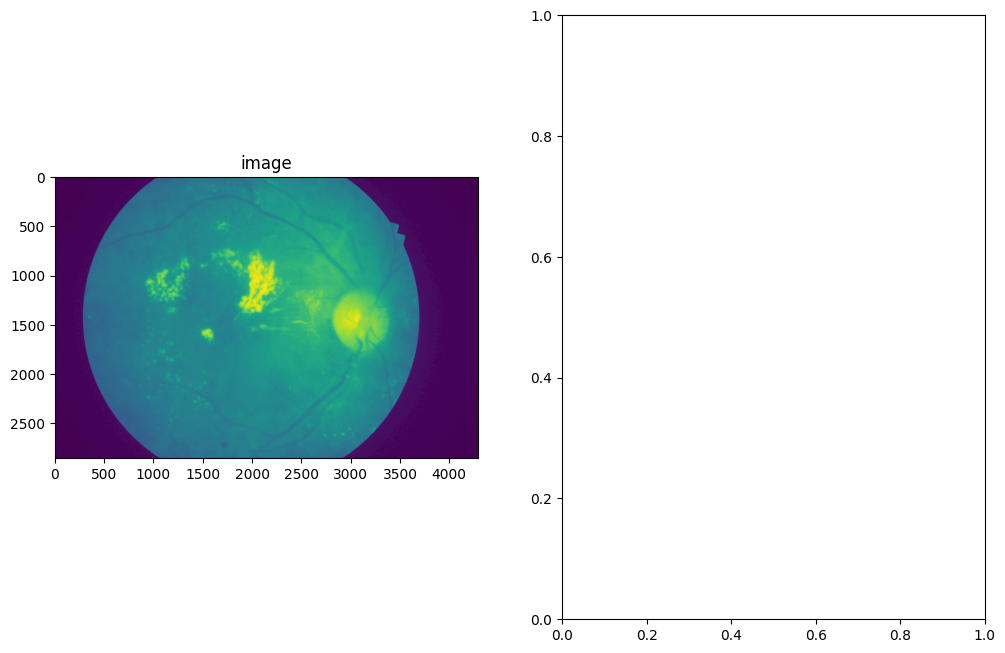